In [1]:
# Standard Python imports
import os
import copy
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Astropy imports
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import ImageNormalize, LogStretch
import astropy.io.fits as pyfits

# Lenstronomy imports
import lenstronomy
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Data.psf import PSF
from lenstronomy.Util import kernel_util
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Workflow.fitting_sequence import FittingSequence



/gpfs/home/rmbrady/miniconda3/envs/doubles/lib/python3.12/site-packages/lenstronomy/Data/psf.py:95: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn(
/tmp/ipykernel_298215/1595508132.py:15: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(kernel_psf_class))


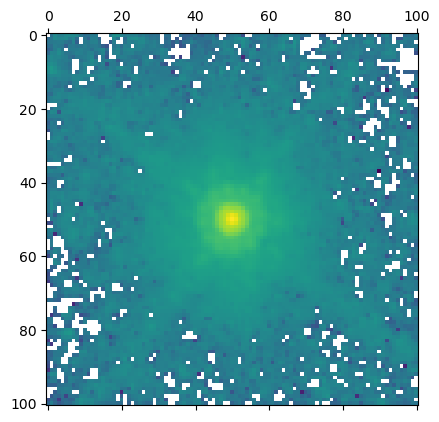

In [2]:
# load PSF data
psf_file = 'outputs/full_PSF.fits'

kernel = pyfits.getdata(psf_file)
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 301

kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf = {'psf_type': psf_type, 'kernel_point_source': kernel_cut, 
              'point_source_supersampling_factor': 3}
psf_class = PSF(**kwargs_psf)

kernel_psf_class = psf_class.kernel_point_source

plt.matshow(np.log10(kernel_psf_class))
plt.show()

In [3]:
# Open the FITS file and extract the header
filename = 'J1620+1203_F814W_cutout.fits'

with fits.open(filename) as hdul:
    header = hdul[0].header
    image_data = hdul[0].data 

# read out matrix elements and convert them in units of arc seconds
CD1_1 = header['CD1_1'] * 3600  # change in arc sec per pixel d(ra)/dx
CD1_2 = header['CD1_2'] * 3600
CD2_1 = header['CD2_1'] * 3600
CD2_2 = header['CD2_2'] * 3600

# generate pixel-to-coordinate transform matrix and its inverse
pix2coord_transform_undistorted = np.array([[CD1_1, CD1_2], [CD2_1, CD2_2]])
det = CD1_1*CD2_2 - CD1_2*CD2_1
coord2pix_transform_undistorted = np.array([[CD2_2, -CD1_2], [-CD2_1, CD1_1]])/det

# as an example, we set the coordinate zero point in the center of the image and compute 
# the coordinate at the pixel (0,0) at the edge of the image

# read out pixel size of image
nx = header.get('NAXIS1')
ny = header.get('NAXIS2')
x_c = int(nx / 2)
y_c = int(ny / 2)

# compute RA/DEC relative shift between the edge and the center of the image
dra, ddec = pix2coord_transform_undistorted.dot(np.array([x_c, y_c]))
# set edge of the image such that the center has RA/DEC = (0,0)
ra_at_xy_0, dec_at_xy_0 = -dra, -ddec

# import the PixelGrid() class #

deltaPix = 0.04  # size of UVIS pixel in angular coordinates #

# setup the keyword arguments to create the Data() class #
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': nx, 'ny': ny,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)
# return the list of pixel coordinates #
x_coords, y_coords = pixel_grid.pixel_coordinates




/tmp/ipykernel_298215/2873581886.py:10: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(image_data), origin='lower', cmap='cubehelix')


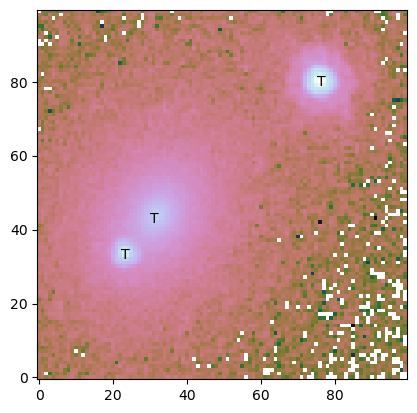

In [4]:
# display science image and obtain coordinates of point source and lens centers
x1, y1 = 75, 79
x2, y2 = 30, 42
x3, y3 = 22,32

plt.annotate('T', [x1,y1], color='black')
plt.annotate('T', [x2,y2], color='black')
plt.annotate('T', [x3,y3], color='black')

plt.imshow(np.log10(image_data), origin='lower', cmap='cubehelix')
plt.show()

im2 = pixel_grid.map_pix2coord(x1, y1)

lens_pos = pixel_grid.map_pix2coord(x2,y2)

im1 = pixel_grid.map_pix2coord(x3,y3)

In [5]:
# set up data class
kwargs_data = {'image_data': image_data,
               'background_rms': header['BACK_RMS'],
               'exposure_time': header['EXPTIME'],
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,
               'transform_pix2angle': transform_pix2angle} 

# lens coordinates
lens_center_x, lens_center_y = lens_pos[0], lens_pos[1]
# image coordinates #
im1_x, im1_y = im1[0], im1[1]
im2_x, im2_y = im2[0], im2[1]

# calculate the initial guess for theta_E as half the image separation
einstein_rad = np.sqrt((im2_x - im1_x)**2 + (im2_y - im1_y)**2) / 2
print(f'Initial guess for theta_E: {einstein_rad}')

# set up point source and lens positions
theta_ra = np.array([im1_x, im2_x])
theta_dec = np.array([im1_y, im2_y])

Initial guess for theta_E: 1.416756859873987


In [6]:
# model parameters
lens_model_list = ['EPL', 'SHEAR']

lens_light_model_list = ['SERSIC_ELLIPSE']

source_model_list = ['SERSIC_ELLIPSE']

point_source_list = ['LENSED_POSITION']

In [7]:
# set up model arguments

kwargs_model = {'lens_model_list': lens_model_list,
                               'lens_light_model_list': lens_light_model_list,
                               'point_source_model_list': point_source_list,
                               'source_light_model_list': source_model_list}

kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False,
                   'point_source_supersampling_factor': 3}


kwargs_constraints = {'num_point_source_list': [2],
                              'joint_lens_with_light': [[0, 0, ['center_x', 'center_y']]],
                              'joint_source_with_point_source': [[0, 0]],
                              }

kwargs_likelihood = {'check_bounds': True,
                     #'image_likelihood_mask_list': [mask_img],
                      #'image_position_uncertainty': 0.004,
                        #'check_matched_source_position': True,
                        'source_position_likelihood': True,
                              'source_position_tolerance': 0.001
                              }

image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}

/gpfs/home/rmbrady/miniconda3/envs/doubles/lib/python3.12/site-packages/lenstronomy/LensModel/Profiles/epl.py:297: RuntimeWarning: invalid value encountered in divide
  R_omega = Z * hyp2f1(1, t / 2, 2 - t / 2, -(1 - q) / (1 + q) * (Z / Z.conj()))


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [01:42<?, ?it/s]


/gpfs/home/rmbrady/miniconda3/envs/doubles/lib/python3.12/site-packages/lenstronomy/Plots/model_band_plot.py:160: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),


-1.2463267450120004 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.246326745012


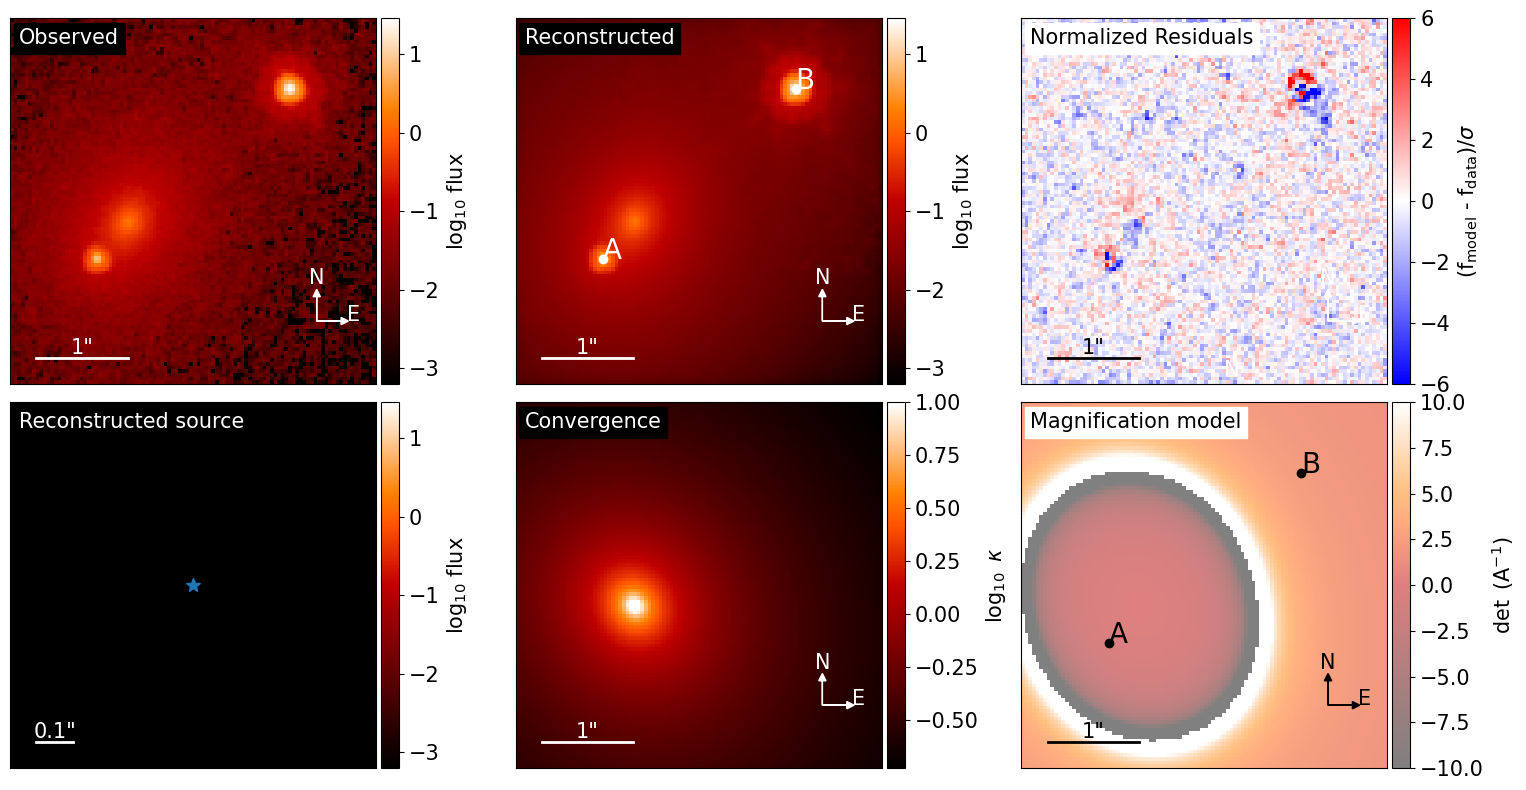

In [8]:
# initial guess of non-linear parameters
kwargs_lens_init = [{'theta_E': einstein_rad, 'gamma': 2., 'e1': 0., 'e2': 0., 'center_x': lens_center_x, 'center_y': lens_center_y},
                    {'gamma1': 0., 'gamma2': 0., 'ra_0': 0, 'dec_0': 0}]
kwargs_lens_light_init = [{'R_sersic': 1., 'n_sersic': 2., 'e1': 0, 'e2': 0, 'center_x': lens_center_x, 'center_y': lens_center_y}]
kwargs_source_init = [{'R_sersic': 0.3, 'n_sersic': 1., 'e1': 0., 'e2': 0., 'center_x': lens_center_x, 'center_y': lens_center_y}]
kwargs_ps_init = [{'ra_image': theta_ra, 'dec_image': theta_dec}]

# initial spread in parameter estimation #
kwargs_lens_sigma = [{'theta_E': 0.2, 'gamma': .5, 'e1': .5, 'e2': .5, 'center_x': 0.1, 'center_y': 0.1},
                     {'gamma1': .1, 'gamma2': .1}]
kwargs_lens_light_sigma = [{'R_sersic': .5, 'n_sersic': .5, 'e1': .1, 'e2': .1, 'center_x': .1, 'center_y': 0.1}]
kwargs_source_sigma = [{'R_sersic': .5, 'n_sersic': .5, 'e1': 0.1, 'e2': 0.1, 'center_x': .1, 'center_y': .1}]
kwargs_ps_sigma = [{'ra_image': [0.02] * 2, 'dec_image': [0.02] * 2}]

# hard bound lower limit in parameter space #
kwargs_lower_lens = [{'theta_E': 0.01, 'gamma': 1., 'e1': -0.15, 'e2': -0.15, 'center_x': -10., 'center_y': -10},
                     {'gamma1': -0.3, 'gamma2': -0.3}]
kwargs_lower_lens_light = [{'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.15, 'e2': - 0.15, 'center_x': -10, 'center_y': -10}]
kwargs_lower_source = [{'R_sersic': 0.001, 'n_sersic': .5, 'e1': -0.15, 'e2': -0.15, 'center_x': -10, 'center_y': -10}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones_like(theta_ra), 'dec_image': -10 * np.ones_like(theta_dec)}]

# hard bound upper limit in parameter space #
kwargs_upper_lens = [{'theta_E': 10, 'gamma': 3., 'e1': 0.15, 'e2': 0.15, 'center_x': 10., 'center_y': 10},
                     {'gamma1': 0.3, 'gamma2': 0.3}]
kwargs_upper_lens_light = [{'R_sersic': 10, 'n_sersic': 5., 'e1': 0.15, 'e2': 0.15, 'center_x': 10, 'center_y': 10}]
kwargs_upper_source = [{'R_sersic': 1., 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}]
kwargs_upper_ps = [{'ra_image': 10 * np.ones_like(theta_ra), 'dec_image': 10 * np.ones_like(theta_dec)}]


lens_params = [kwargs_lens_init, kwargs_lens_sigma, [{'gamma': 2}, {'ra_0': 0, 'dec_0': 0}], kwargs_lower_lens, kwargs_upper_lens]
lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, [{}], kwargs_lower_lens_light, kwargs_upper_lens_light]
source_params = [kwargs_source_init, kwargs_source_sigma, [{}], kwargs_lower_source, kwargs_upper_source]
ps_params = [kwargs_ps_init, kwargs_ps_sigma, [{}], kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_model': lens_params,
                 'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params}

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, verbose=False)


fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 100}]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
multi_band_list = fitting_seq.multi_band_list

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main()
f

iteration of step 2 gave best reconstruction.
log likelihood before: -6231.633725060002 and log likelihood after: -5669.7989893009535


/gpfs/home/rmbrady/miniconda3/envs/doubles/lib/python3.12/site-packages/lenstronomy/Plots/chain_plot.py:138: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(psf_in), origin="lower", **kwargs)
/gpfs/home/rmbrady/miniconda3/envs/doubles/lib/python3.12/site-packages/lenstronomy/Plots/chain_plot.py:159: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(psf_out), origin="lower", **kwargs)
/gpfs/home/rmbrady/miniconda3/envs/doubles/lib/python3.12/site-packages/lenstronomy/Plots/chain_plot.py:200: RuntimeWarning: divide by zero encountered in log10
  np.log10(psf_variance_map * psf.kernel_point_source**2),


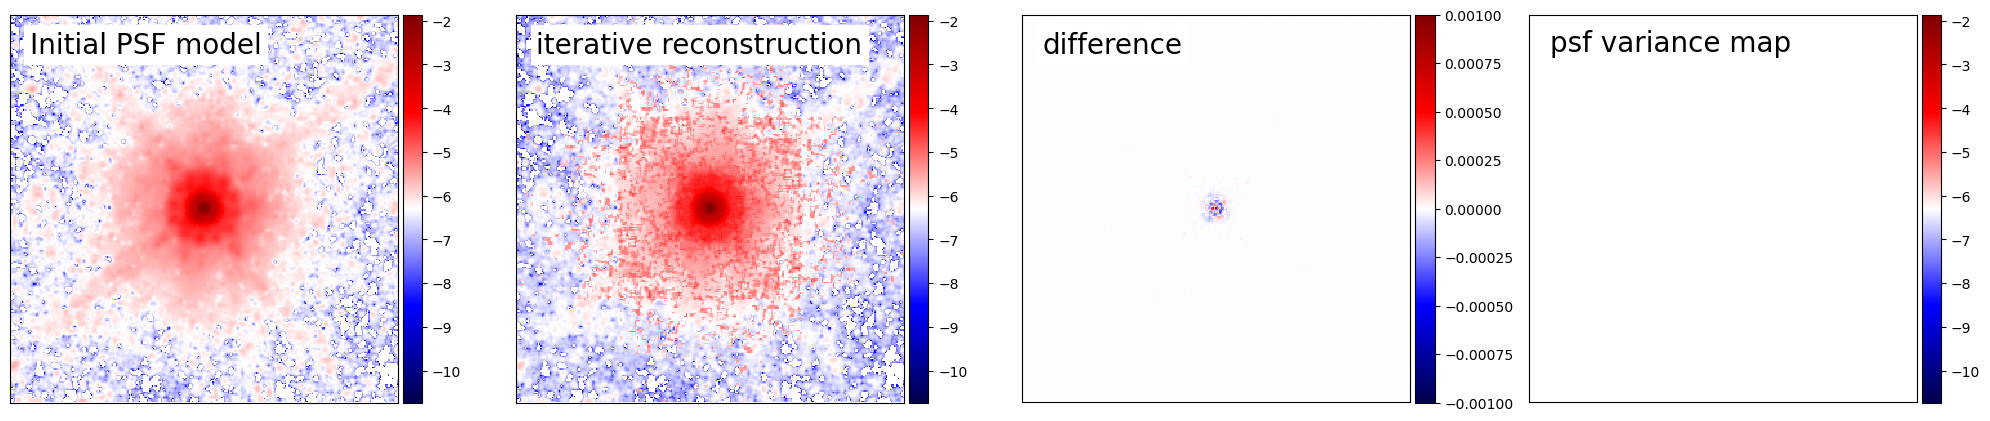

-1.1339597978601907 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.1339597978601903


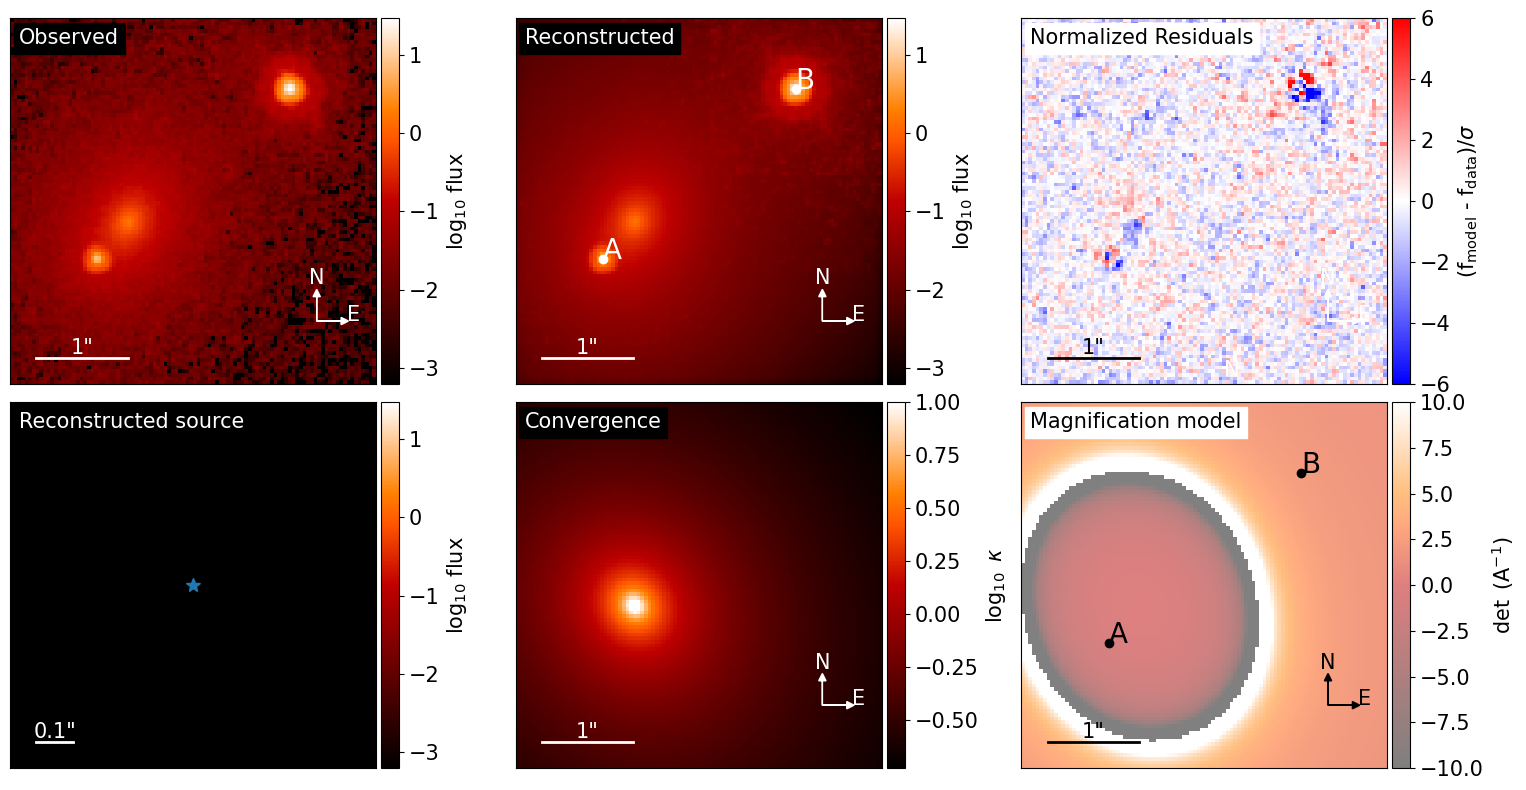

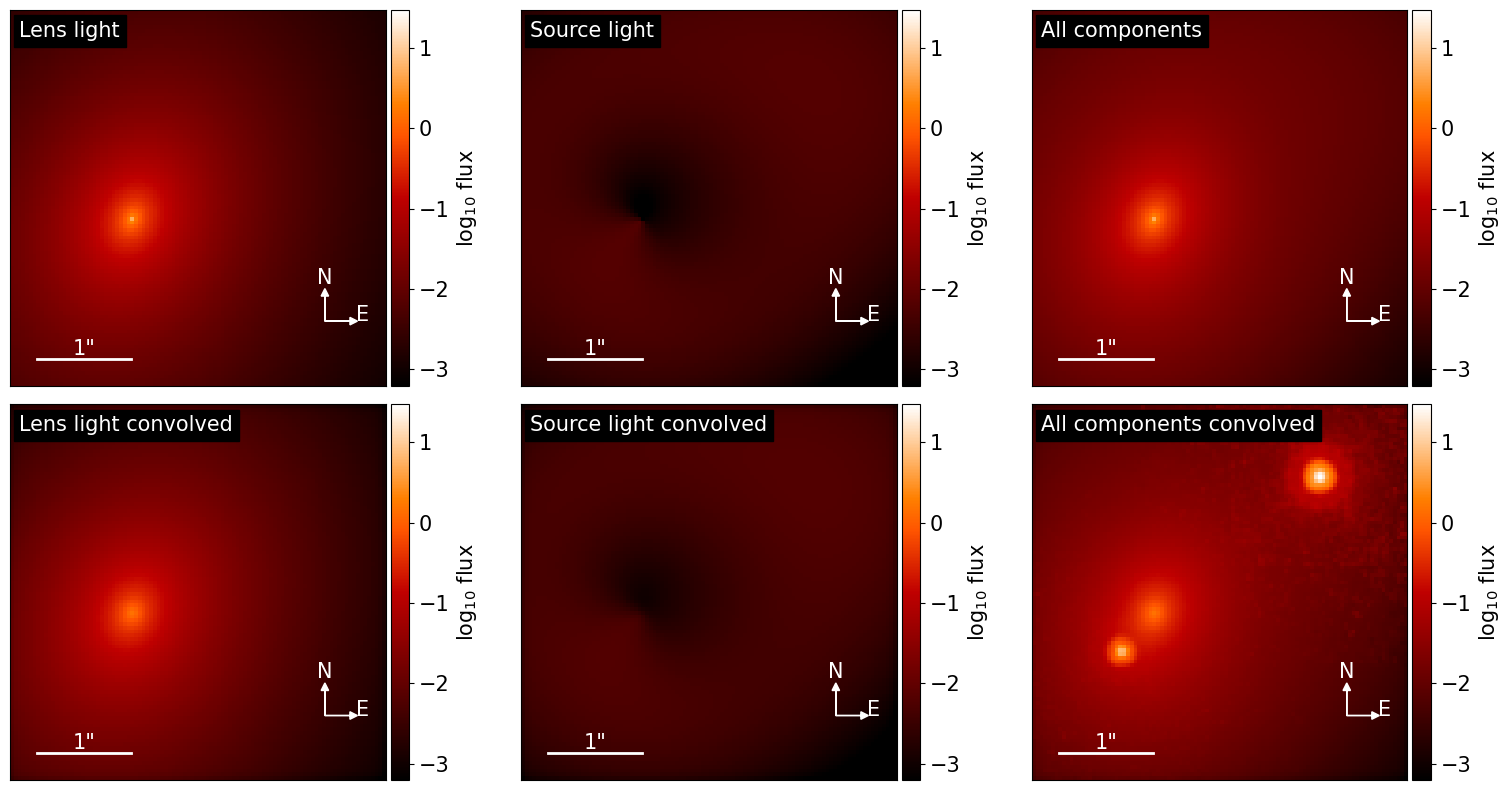

/gpfs/home/rmbrady/miniconda3/envs/doubles/lib/python3.12/site-packages/lenstronomy/Plots/model_band_plot.py:1168: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data - model),


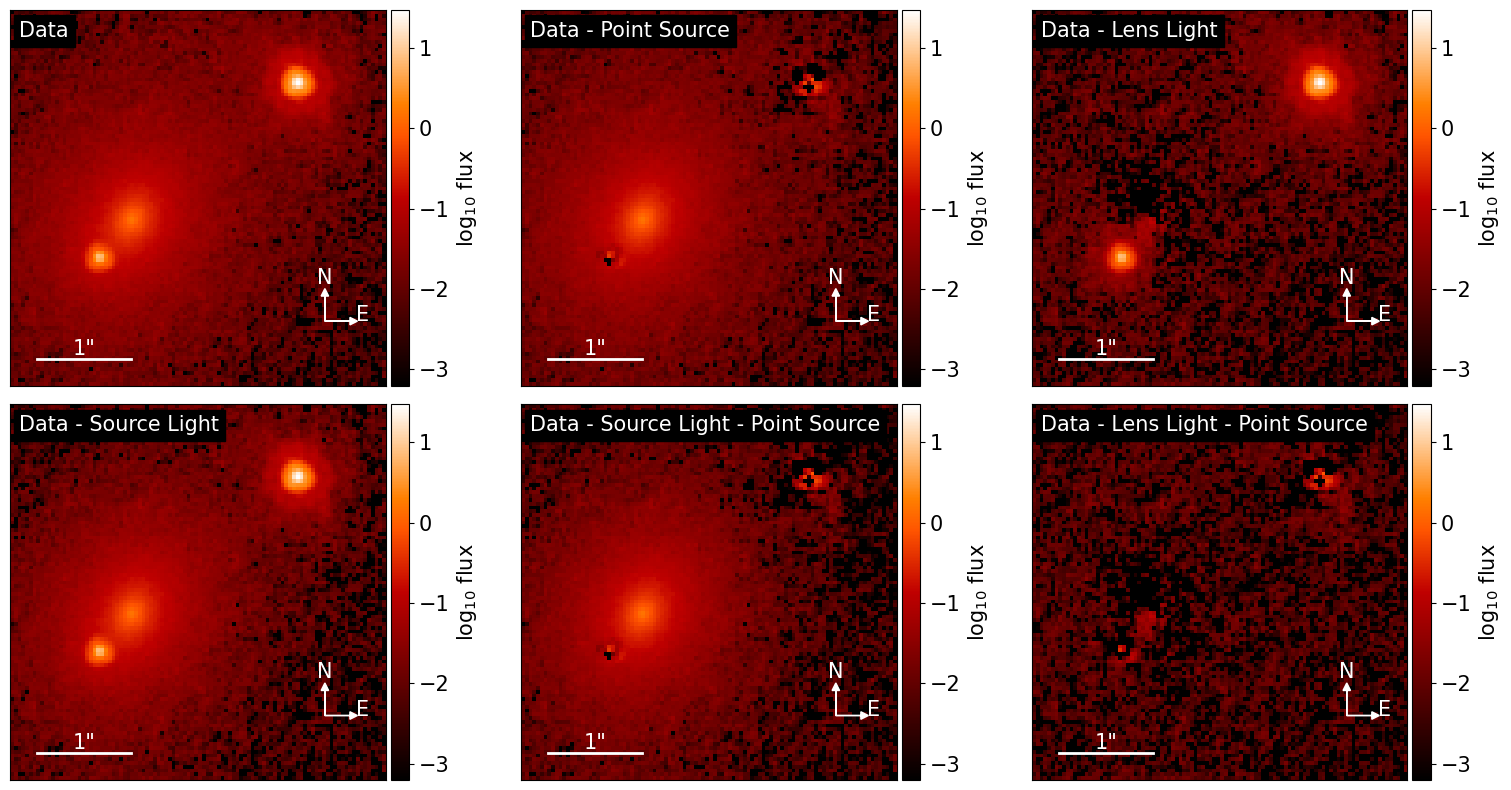

In [9]:
#now we run an iterative PSF reconstruction with the best fit model of the previous run
method_PSF_iteration = 'stack' #use 'STARRED' to use the STARRED method for PSF reconstruction or 'stack' to use the standard lenstronomy stacking method

kwargs_lbfgs = {'maxiter':1000}

kwargs_optax1 = {'max_iterations': 500, 'min_iterations': None,
                'init_learning_rate': 1e-2, 'schedule_learning_rate': True,
                'progress_bar': True} 

if method_PSF_iteration == 'STARRED':
    kwargs_psf_iter = { 
                    'keep_psf_error_map': True, 
                    'psf_symmetry': 1, 
                    'block_center_neighbour': 0.05,
                    'num_iter': 3, #we run STARRED more than once, to see if the chi2 keeps improving after redoing the linear inversion with the new PSF. 
                    'psf_iter_factor': 1, #We fully update the PSF at each iteration, if the fit improves
                    'kwargs_starred': {'verbose':True, 'lambda_scales':3, 'lambda_hf':3, #Choose regularisation parameters, lambda_scales and lambda_hf should be 2 or 3 if the noise is correctly scaled 
                                       'optim_list':['adabelief', 'adabelief'], 'kwargs_optim_list':[kwargs_optax1, kwargs_optax1],#Choose the optimisers to use, and pass the kwargs accordingly. One for the Moffat fit, one for the full PSF fit. 
                                       }, 
                    'use_starred': True, 
                    } 

else: 
    kwargs_psf_iter = {'stacking_method': 'median', 
                    'psf_symmetry': 4, 
                    'block_center_neighbour': 0.05,
                    'num_iter': 500, 
                    'psf_iter_factor': 0.2}

fitting_kwargs_list = [['psf_iteration', kwargs_psf_iter]]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)

multi_band_list = fitting_seq.multi_band_list
kwargs_psf_updated = multi_band_list[0][1]

from IPython.display import display

f, axes = chain_plot.psf_iteration_compare(kwargs_psf_updated)
display(f)

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")

f, axes = modelPlot.plot_main()
display(f)

f, axes = modelPlot.plot_separate()
display(f)

f, axes = modelPlot.plot_subtract_from_data_all()
display(f)


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [10:31<?, ?it/s]

iteration of step 0 gave best reconstruction.
log likelihood before: -5441.074174439576 and log likelihood after: -5441.074174439576


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [01:44<?, ?it/s]

iteration of step 0 gave best reconstruction.
log likelihood before: -5440.864293148277 and log likelihood after: -5440.864293148277


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [10:33<?, ?it/s]

iteration of step 0 gave best reconstruction.
log likelihood before: -5439.088064179093 and log likelihood after: -5439.088064179093


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [01:35<?, ?it/s]

iteration of step 0 gave best reconstruction.
log likelihood before: -5438.919984320926 and log likelihood after: -5438.919984320926
-1.0877839968641851 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.0877839968641851


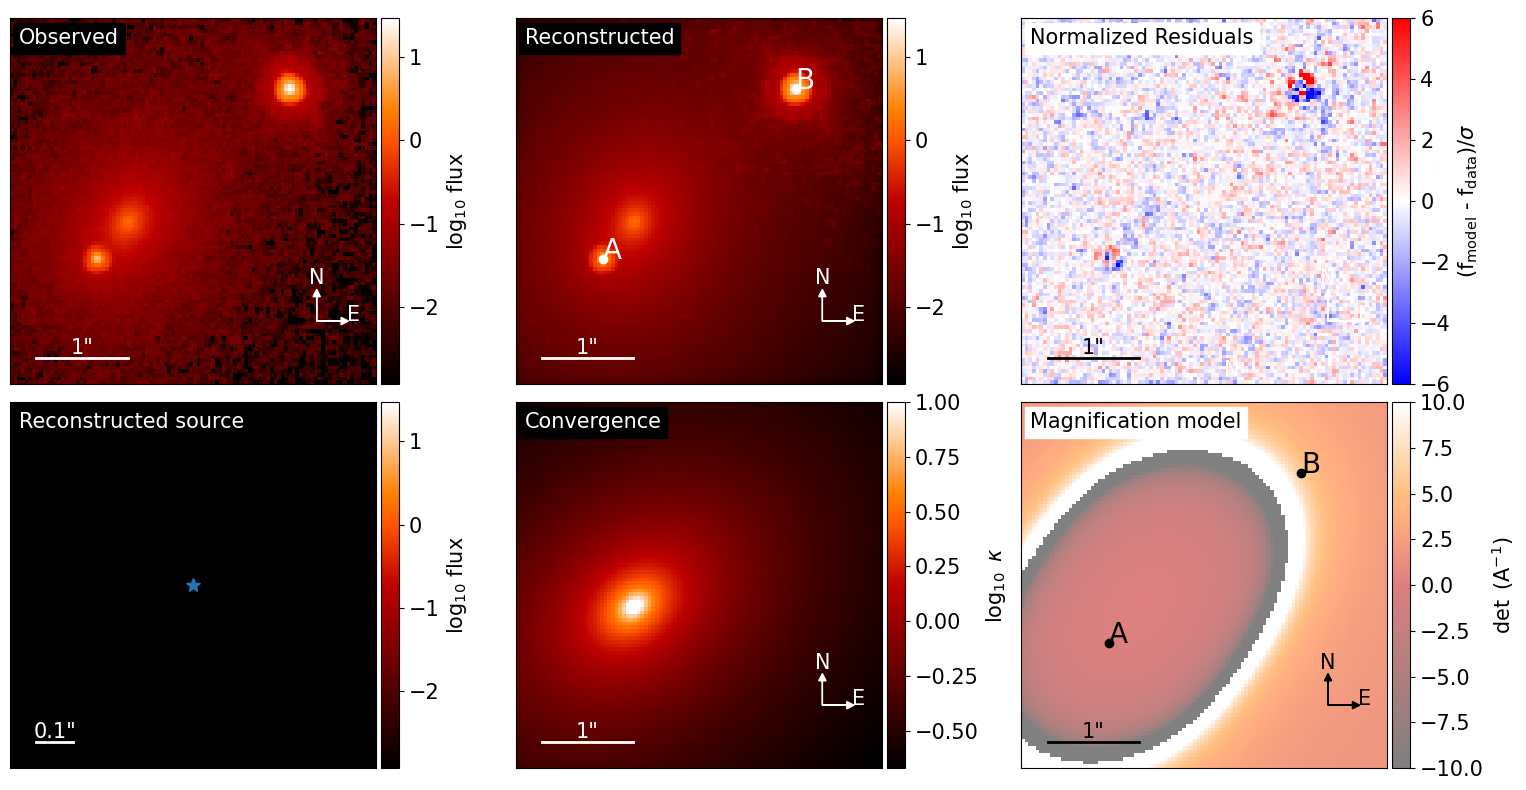

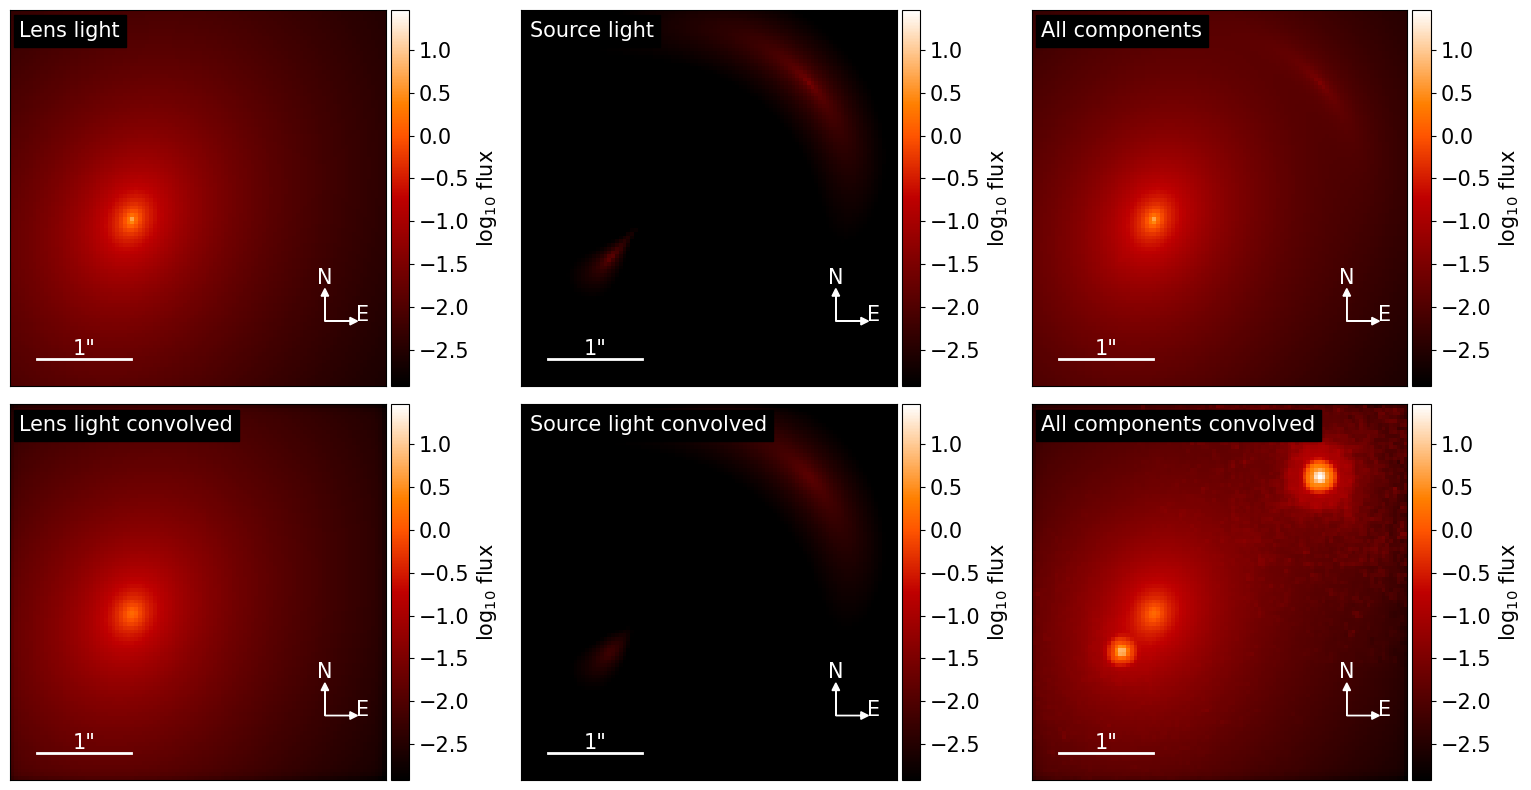

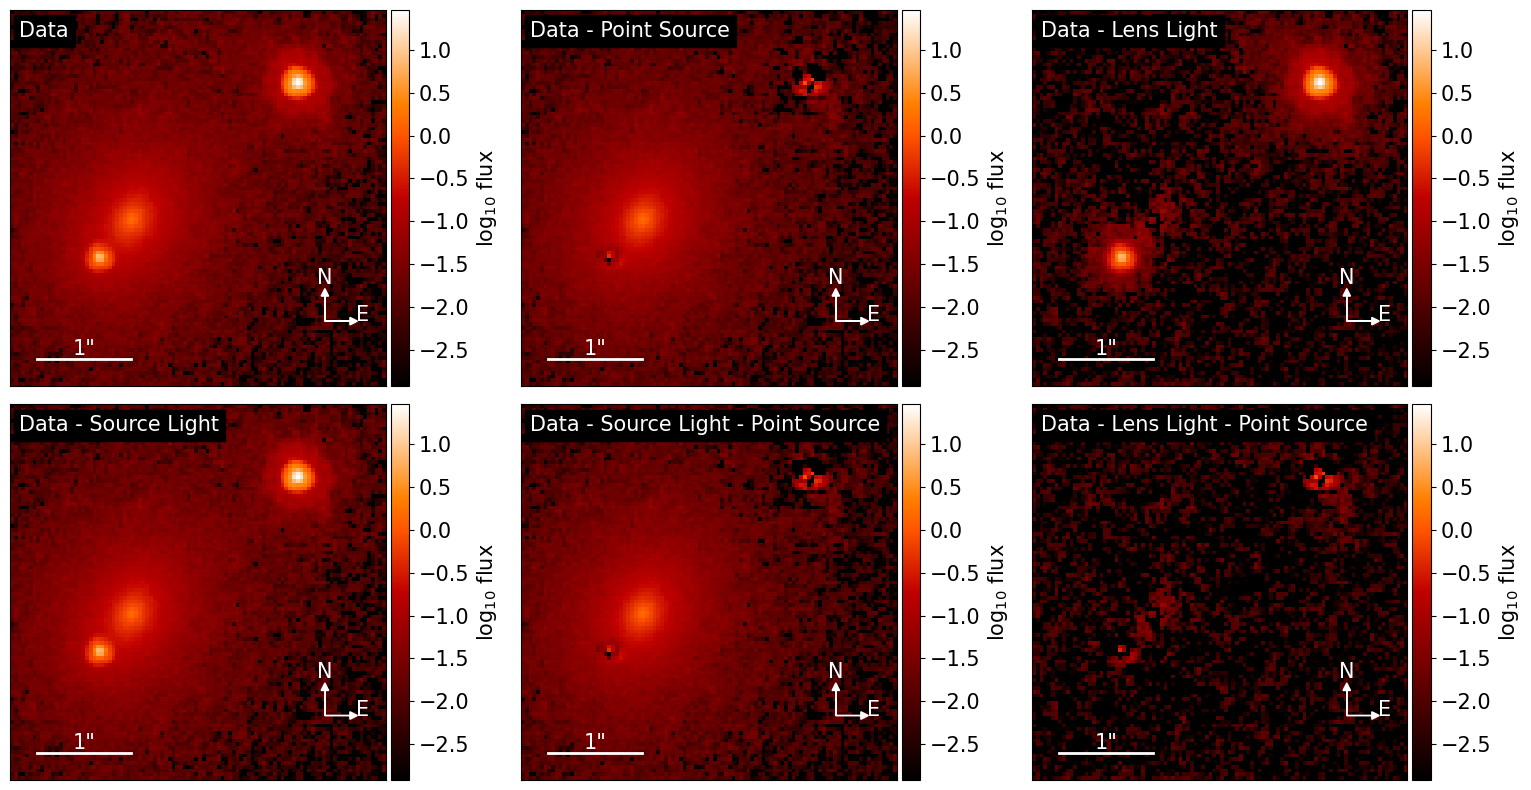

In [10]:
# run the fitting again with more iterations
fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 500}],
                       ['psf_iteration', kwargs_psf_iter],
                       ['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 500}],
                       ['psf_iteration', kwargs_psf_iter],
                       ['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 500}],
                       ['psf_iteration', kwargs_psf_iter],
                       ['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 500}],
                       ['psf_iteration', kwargs_psf_iter]
]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
multi_band_list = fitting_seq.multi_band_list

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main()
display(f)

f, axes = modelPlot.plot_separate()
display(f)

f, axes = modelPlot.plot_subtract_from_data_all()
display(f)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [02:33<?, ?it/s]

iteration of step 0 gave best reconstruction.
log likelihood before: -5438.819124976764 and log likelihood after: -5438.819124976764
MCMC selected. Sampling with default option emcee.


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 1/200 [00:02<07:42,  2.32s/it]

  1%|          | 2/200 [00:04<07:46,  2.36s/it]

  2%|▏         | 3/200 [00:07<07:41,  2.34s/it]

  2%|▏         | 4/200 [00:09<07:54,  2.42s/it]

  2%|▎         | 5/200 [00:12<08:00,  2.47s/it]

  3%|▎         | 6/200 [00:14<08:01,  2.48s/it]

  4%|▎         | 7/200 [00:17<08:12,  2.55s/it]

  4%|▍         | 8/200 [00:20<08:18,  2.59s/it]

  4%|▍         | 9/200 [00:22<08:22,  2.63s/it]

  5%|▌         | 10/200 [00:25<08:29,  2.68s/it]

  6%|▌         | 11/200 [00:28<08:38,  2.74s/it]

  6%|▌         | 12/200 [00:31<08:44,  2.79s/it]

  6%|▋         | 13/200 [00:34<08:46,  2.82s/it]

  7%|▋         | 14/200 [00:37<08:49,  2.84s/it]

  8%|▊         | 15/200 [00:40<08:54,  2.89s/it]

  8%|▊         | 16/200 [00:42<08:49,  2.88s/it]

  8%|▊         | 17/200 [00:45<08:50,  2.90s/it]

  9%|▉         | 18/200 [00:48<08:56,  2.95s/it]

 10%|▉         | 19/200 [00:52<09:00,  2.99s/it]

 10%|█         | 20/200 [00:55<09:01,  3.01s/it]

 10%|█         | 21/200 [00:58<09:00,  3.02s/it]

 11%|█         | 22/200 [01:01<08:55,  3.01s/it]

 12%|█▏        | 23/200 [01:04<08:56,  3.03s/it]

 12%|█▏        | 24/200 [01:07<08:57,  3.05s/it]

 12%|█▎        | 25/200 [01:10<08:57,  3.07s/it]

 13%|█▎        | 26/200 [01:13<08:57,  3.09s/it]

 14%|█▎        | 27/200 [01:16<08:56,  3.10s/it]

 14%|█▍        | 28/200 [01:19<08:54,  3.11s/it]

 14%|█▍        | 29/200 [01:22<08:53,  3.12s/it]

 15%|█▌        | 30/200 [01:26<08:48,  3.11s/it]

 16%|█▌        | 31/200 [01:29<08:46,  3.12s/it]

 16%|█▌        | 32/200 [01:32<08:44,  3.12s/it]

 16%|█▋        | 33/200 [01:35<08:41,  3.12s/it]

 17%|█▋        | 34/200 [01:38<08:38,  3.13s/it]

 18%|█▊        | 35/200 [01:41<08:35,  3.13s/it]

 18%|█▊        | 36/200 [01:44<08:33,  3.13s/it]

 18%|█▊        | 37/200 [01:47<08:29,  3.13s/it]

 19%|█▉        | 38/200 [01:51<08:25,  3.12s/it]

 20%|█▉        | 39/200 [01:54<08:22,  3.12s/it]

 20%|██        | 40/200 [01:57<08:17,  3.11s/it]

 20%|██        | 41/200 [02:00<08:15,  3.11s/it]

 21%|██        | 42/200 [02:03<08:13,  3.12s/it]

 22%|██▏       | 43/200 [02:06<08:11,  3.13s/it]

 22%|██▏       | 44/200 [02:09<08:08,  3.13s/it]

 22%|██▎       | 45/200 [02:12<08:05,  3.14s/it]

 23%|██▎       | 46/200 [02:16<08:02,  3.13s/it]

 24%|██▎       | 47/200 [02:19<07:59,  3.13s/it]

 24%|██▍       | 48/200 [02:22<07:56,  3.14s/it]

 24%|██▍       | 49/200 [02:25<07:54,  3.14s/it]

 25%|██▌       | 50/200 [02:28<07:51,  3.14s/it]

 26%|██▌       | 51/200 [02:31<07:46,  3.13s/it]

 26%|██▌       | 52/200 [02:34<07:43,  3.13s/it]

 26%|██▋       | 53/200 [02:38<07:41,  3.14s/it]

 27%|██▋       | 54/200 [02:41<07:38,  3.14s/it]

 28%|██▊       | 55/200 [02:44<07:33,  3.13s/it]

 28%|██▊       | 56/200 [02:47<07:29,  3.12s/it]

 28%|██▊       | 57/200 [02:50<07:25,  3.11s/it]

 29%|██▉       | 58/200 [02:53<07:22,  3.12s/it]

 30%|██▉       | 59/200 [02:56<07:19,  3.12s/it]

 30%|███       | 60/200 [02:59<07:17,  3.13s/it]

 30%|███       | 61/200 [03:02<07:14,  3.13s/it]

 31%|███       | 62/200 [03:06<07:10,  3.12s/it]

 32%|███▏      | 63/200 [03:09<07:07,  3.12s/it]

 32%|███▏      | 64/200 [03:12<07:04,  3.12s/it]

 32%|███▎      | 65/200 [03:15<07:01,  3.12s/it]

 33%|███▎      | 66/200 [03:18<06:57,  3.12s/it]

 34%|███▎      | 67/200 [03:21<06:54,  3.12s/it]

 34%|███▍      | 68/200 [03:24<06:52,  3.12s/it]

 34%|███▍      | 69/200 [03:27<06:49,  3.13s/it]

 35%|███▌      | 70/200 [03:31<06:47,  3.13s/it]

 36%|███▌      | 71/200 [03:34<06:43,  3.13s/it]

 36%|███▌      | 72/200 [03:37<06:40,  3.13s/it]

 36%|███▋      | 73/200 [03:40<06:36,  3.12s/it]

 37%|███▋      | 74/200 [03:43<06:32,  3.12s/it]

 38%|███▊      | 75/200 [03:46<06:28,  3.11s/it]

 38%|███▊      | 76/200 [03:49<06:25,  3.11s/it]

 38%|███▊      | 77/200 [03:52<06:22,  3.11s/it]

 39%|███▉      | 78/200 [03:55<06:19,  3.11s/it]

 40%|███▉      | 79/200 [03:59<06:16,  3.11s/it]

 40%|████      | 80/200 [04:02<06:14,  3.12s/it]

 40%|████      | 81/200 [04:05<06:11,  3.12s/it]

 41%|████      | 82/200 [04:08<06:08,  3.12s/it]

 42%|████▏     | 83/200 [04:11<06:04,  3.11s/it]

 42%|████▏     | 84/200 [04:14<06:00,  3.11s/it]

 42%|████▎     | 85/200 [04:17<05:57,  3.11s/it]

 43%|████▎     | 86/200 [04:20<05:53,  3.10s/it]

 44%|████▎     | 87/200 [04:23<05:48,  3.09s/it]

 44%|████▍     | 88/200 [04:27<05:46,  3.10s/it]

 44%|████▍     | 89/200 [04:30<05:42,  3.08s/it]

 45%|████▌     | 90/200 [04:33<05:39,  3.09s/it]

 46%|████▌     | 91/200 [04:36<05:36,  3.09s/it]

 46%|████▌     | 92/200 [04:39<05:34,  3.10s/it]

 46%|████▋     | 93/200 [04:42<05:31,  3.09s/it]

 47%|████▋     | 94/200 [04:45<05:27,  3.09s/it]

 48%|████▊     | 95/200 [04:48<05:22,  3.07s/it]

 48%|████▊     | 96/200 [04:51<05:17,  3.06s/it]

 48%|████▊     | 97/200 [04:54<05:15,  3.07s/it]

 49%|████▉     | 98/200 [04:57<05:12,  3.06s/it]

 50%|████▉     | 99/200 [05:00<05:09,  3.06s/it]

 50%|█████     | 100/200 [05:03<05:07,  3.08s/it]

 50%|█████     | 101/200 [05:07<05:04,  3.08s/it]

 51%|█████     | 102/200 [05:10<05:00,  3.07s/it]

 52%|█████▏    | 103/200 [05:13<04:56,  3.05s/it]

 52%|█████▏    | 104/200 [05:16<04:53,  3.05s/it]

 52%|█████▎    | 105/200 [05:19<04:50,  3.05s/it]

 53%|█████▎    | 106/200 [05:22<04:46,  3.04s/it]

 54%|█████▎    | 107/200 [05:25<04:41,  3.03s/it]

 54%|█████▍    | 108/200 [05:28<04:39,  3.03s/it]

 55%|█████▍    | 109/200 [05:31<04:35,  3.03s/it]

 55%|█████▌    | 110/200 [05:34<04:30,  3.01s/it]

 56%|█████▌    | 111/200 [05:37<04:30,  3.03s/it]

 56%|█████▌    | 112/200 [05:40<04:27,  3.04s/it]

 56%|█████▋    | 113/200 [05:43<04:24,  3.04s/it]

 57%|█████▋    | 114/200 [05:46<04:20,  3.03s/it]

 57%|█████▊    | 115/200 [05:49<04:18,  3.04s/it]

 58%|█████▊    | 116/200 [05:52<04:12,  3.01s/it]

 58%|█████▊    | 117/200 [05:55<04:08,  3.00s/it]

 59%|█████▉    | 118/200 [05:58<04:05,  2.99s/it]

 60%|█████▉    | 119/200 [06:01<04:02,  2.99s/it]

 60%|██████    | 120/200 [06:04<03:58,  2.99s/it]

 60%|██████    | 121/200 [06:07<03:53,  2.96s/it]

 61%|██████    | 122/200 [06:10<03:51,  2.97s/it]

 62%|██████▏   | 123/200 [06:13<03:49,  2.99s/it]

 62%|██████▏   | 124/200 [06:16<03:47,  3.00s/it]

 62%|██████▎   | 125/200 [06:19<03:44,  2.99s/it]

 63%|██████▎   | 126/200 [06:22<03:39,  2.97s/it]

 64%|██████▎   | 127/200 [06:25<03:35,  2.95s/it]

 64%|██████▍   | 128/200 [06:28<03:33,  2.96s/it]

 64%|██████▍   | 129/200 [06:31<03:30,  2.96s/it]

 65%|██████▌   | 130/200 [06:33<03:24,  2.92s/it]

 66%|██████▌   | 131/200 [06:36<03:23,  2.94s/it]

 66%|██████▌   | 132/200 [06:39<03:18,  2.92s/it]

 66%|██████▋   | 133/200 [06:42<03:14,  2.90s/it]

 67%|██████▋   | 134/200 [06:45<03:10,  2.88s/it]

 68%|██████▊   | 135/200 [06:48<03:07,  2.88s/it]

 68%|██████▊   | 136/200 [06:51<03:03,  2.86s/it]

 68%|██████▊   | 137/200 [06:53<02:59,  2.85s/it]

 69%|██████▉   | 138/200 [06:56<02:55,  2.84s/it]

 70%|██████▉   | 139/200 [06:59<02:54,  2.86s/it]

 70%|███████   | 140/200 [07:02<02:49,  2.83s/it]

 70%|███████   | 141/200 [07:05<02:44,  2.78s/it]

 71%|███████   | 142/200 [07:07<02:41,  2.78s/it]

 72%|███████▏  | 143/200 [07:10<02:37,  2.76s/it]

 72%|███████▏  | 144/200 [07:13<02:35,  2.78s/it]

 72%|███████▎  | 145/200 [07:16<02:31,  2.76s/it]

 73%|███████▎  | 146/200 [07:18<02:29,  2.76s/it]

 74%|███████▎  | 147/200 [07:21<02:26,  2.76s/it]

 74%|███████▍  | 148/200 [07:24<02:22,  2.75s/it]

 74%|███████▍  | 149/200 [07:27<02:19,  2.73s/it]

 75%|███████▌  | 150/200 [07:29<02:17,  2.76s/it]

 76%|███████▌  | 151/200 [07:32<02:14,  2.76s/it]

 76%|███████▌  | 152/200 [07:35<02:11,  2.74s/it]

 76%|███████▋  | 153/200 [07:37<02:06,  2.68s/it]

 77%|███████▋  | 154/200 [07:40<02:01,  2.65s/it]

 78%|███████▊  | 155/200 [07:43<02:01,  2.71s/it]

 78%|███████▊  | 156/200 [07:45<01:59,  2.71s/it]

 78%|███████▊  | 157/200 [07:48<01:56,  2.71s/it]

 79%|███████▉  | 158/200 [07:51<01:54,  2.72s/it]

 80%|███████▉  | 159/200 [07:54<01:52,  2.75s/it]

 80%|████████  | 160/200 [07:57<01:50,  2.75s/it]

 80%|████████  | 161/200 [07:59<01:46,  2.74s/it]

 81%|████████  | 162/200 [08:02<01:44,  2.75s/it]

 82%|████████▏ | 163/200 [08:05<01:41,  2.74s/it]

 82%|████████▏ | 164/200 [08:07<01:38,  2.74s/it]

 82%|████████▎ | 165/200 [08:10<01:35,  2.72s/it]

 83%|████████▎ | 166/200 [08:13<01:30,  2.66s/it]

 84%|████████▎ | 167/200 [08:15<01:28,  2.69s/it]

 84%|████████▍ | 168/200 [08:18<01:26,  2.69s/it]

 84%|████████▍ | 169/200 [08:21<01:25,  2.75s/it]

 85%|████████▌ | 170/200 [08:24<01:20,  2.70s/it]

 86%|████████▌ | 171/200 [08:26<01:18,  2.71s/it]

 86%|████████▌ | 172/200 [08:29<01:16,  2.72s/it]

 86%|████████▋ | 173/200 [08:32<01:12,  2.70s/it]

 87%|████████▋ | 174/200 [08:34<01:10,  2.69s/it]

 88%|████████▊ | 175/200 [08:37<01:08,  2.72s/it]

 88%|████████▊ | 176/200 [08:40<01:04,  2.68s/it]

 88%|████████▊ | 177/200 [08:42<01:01,  2.65s/it]

 89%|████████▉ | 178/200 [08:45<00:57,  2.63s/it]

 90%|████████▉ | 179/200 [08:48<00:55,  2.65s/it]

 90%|█████████ | 180/200 [08:50<00:53,  2.65s/it]

 90%|█████████ | 181/200 [08:53<00:49,  2.62s/it]

 91%|█████████ | 182/200 [08:55<00:46,  2.58s/it]

 92%|█████████▏| 183/200 [08:58<00:43,  2.59s/it]

 92%|█████████▏| 184/200 [09:00<00:41,  2.57s/it]

 92%|█████████▎| 185/200 [09:03<00:38,  2.57s/it]

 93%|█████████▎| 186/200 [09:06<00:35,  2.57s/it]

 94%|█████████▎| 187/200 [09:08<00:33,  2.55s/it]

 94%|█████████▍| 188/200 [09:11<00:30,  2.55s/it]

 94%|█████████▍| 189/200 [09:13<00:27,  2.52s/it]

 95%|█████████▌| 190/200 [09:16<00:24,  2.49s/it]

 96%|█████████▌| 191/200 [09:18<00:22,  2.48s/it]

 96%|█████████▌| 192/200 [09:20<00:19,  2.44s/it]

 96%|█████████▋| 193/200 [09:23<00:17,  2.45s/it]

 97%|█████████▋| 194/200 [09:25<00:15,  2.50s/it]

 98%|█████████▊| 195/200 [09:28<00:12,  2.53s/it]

 98%|█████████▊| 196/200 [09:31<00:10,  2.52s/it]

 98%|█████████▊| 197/200 [09:33<00:07,  2.54s/it]

 99%|█████████▉| 198/200 [09:36<00:05,  2.54s/it]

100%|█████████▉| 199/200 [09:38<00:02,  2.51s/it]

100%|██████████| 200/200 [09:41<00:00,  2.52s/it]

100%|██████████| 200/200 [09:41<00:00,  2.91s/it]

Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  100
Sampling iterations (in current run): 200
584.2837483882904 time taken for MCMC sampling
-1.088405422774893 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.088405422774893


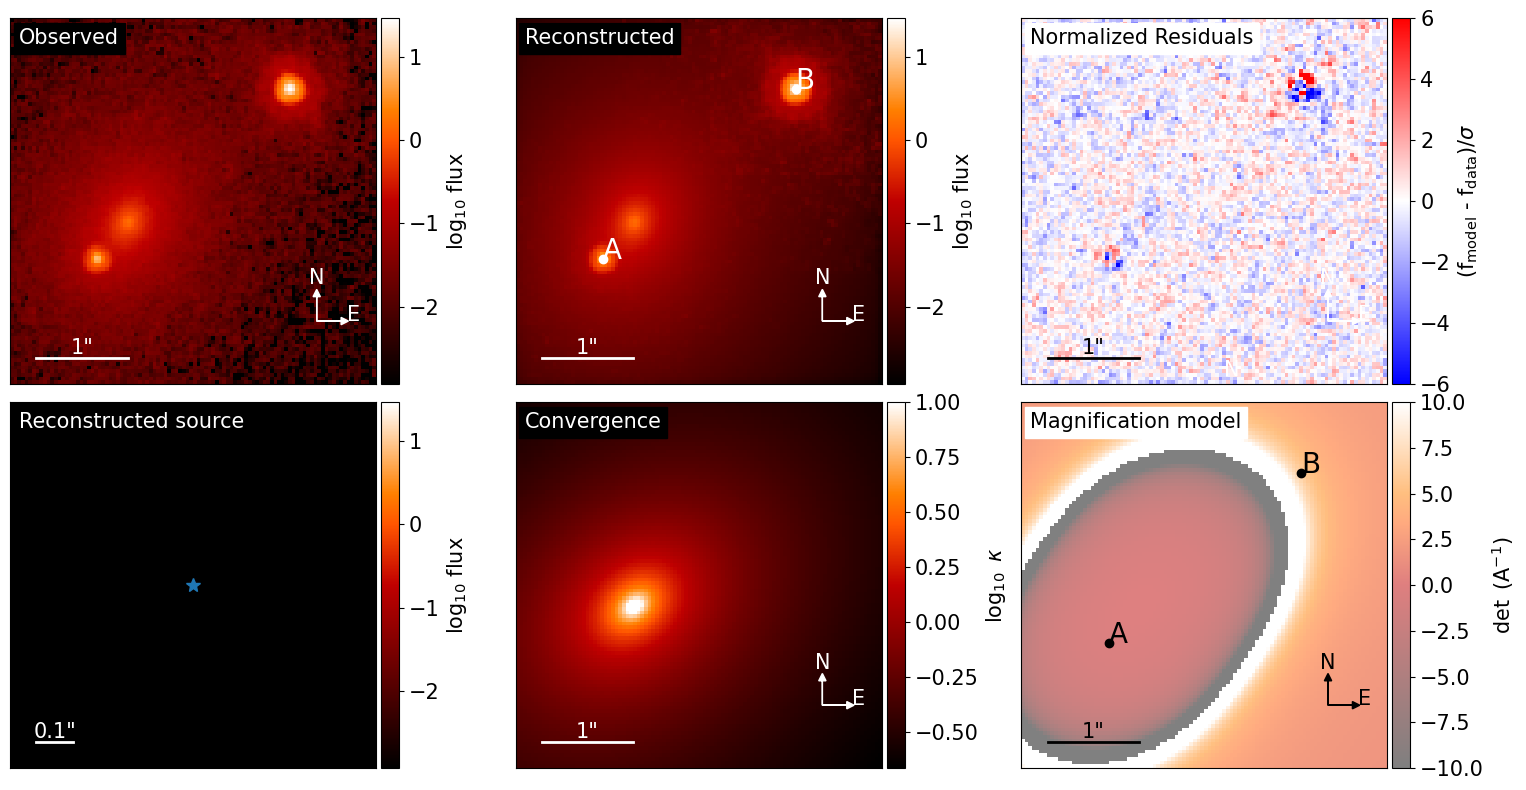

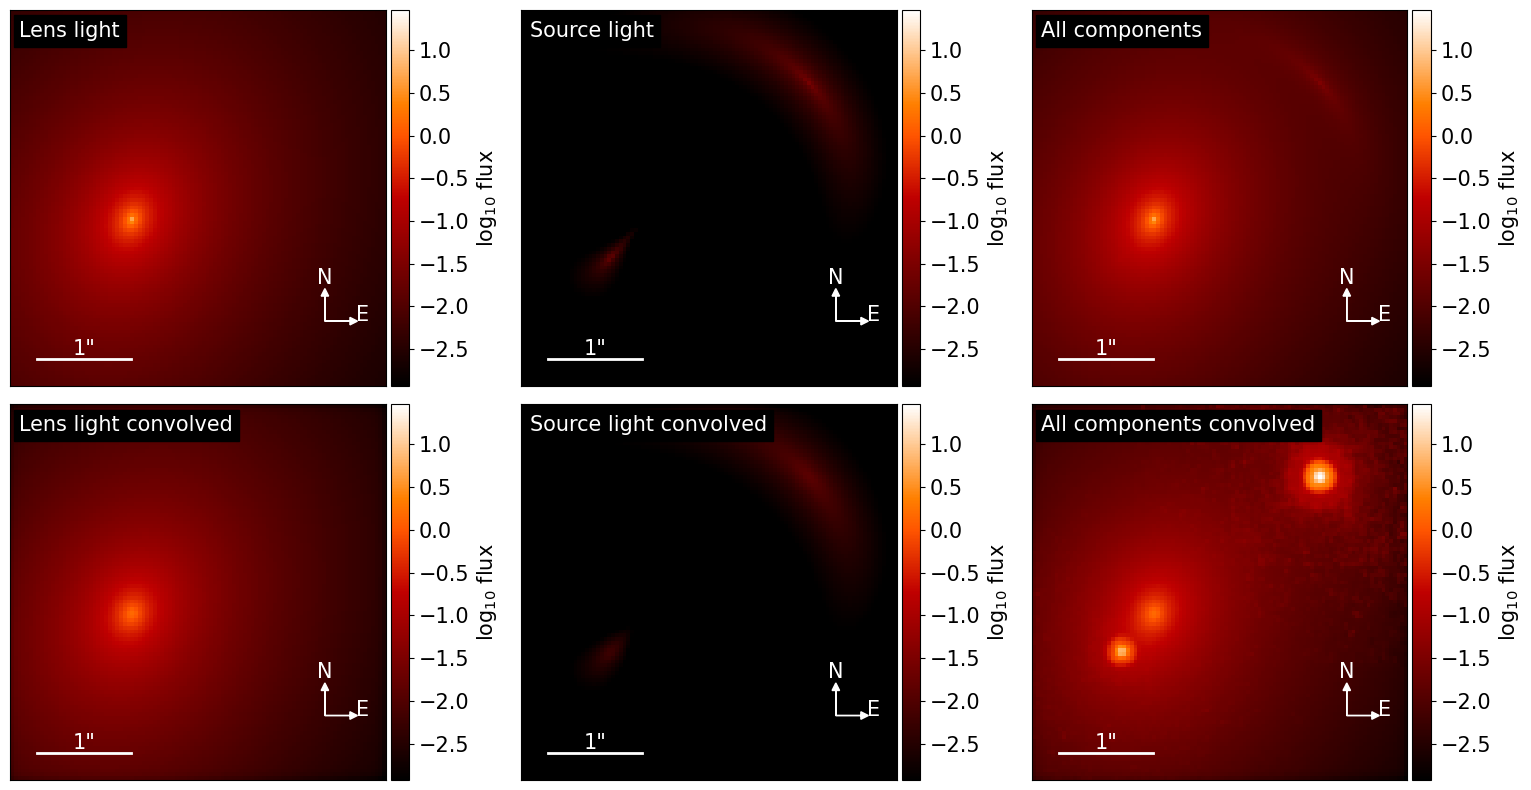

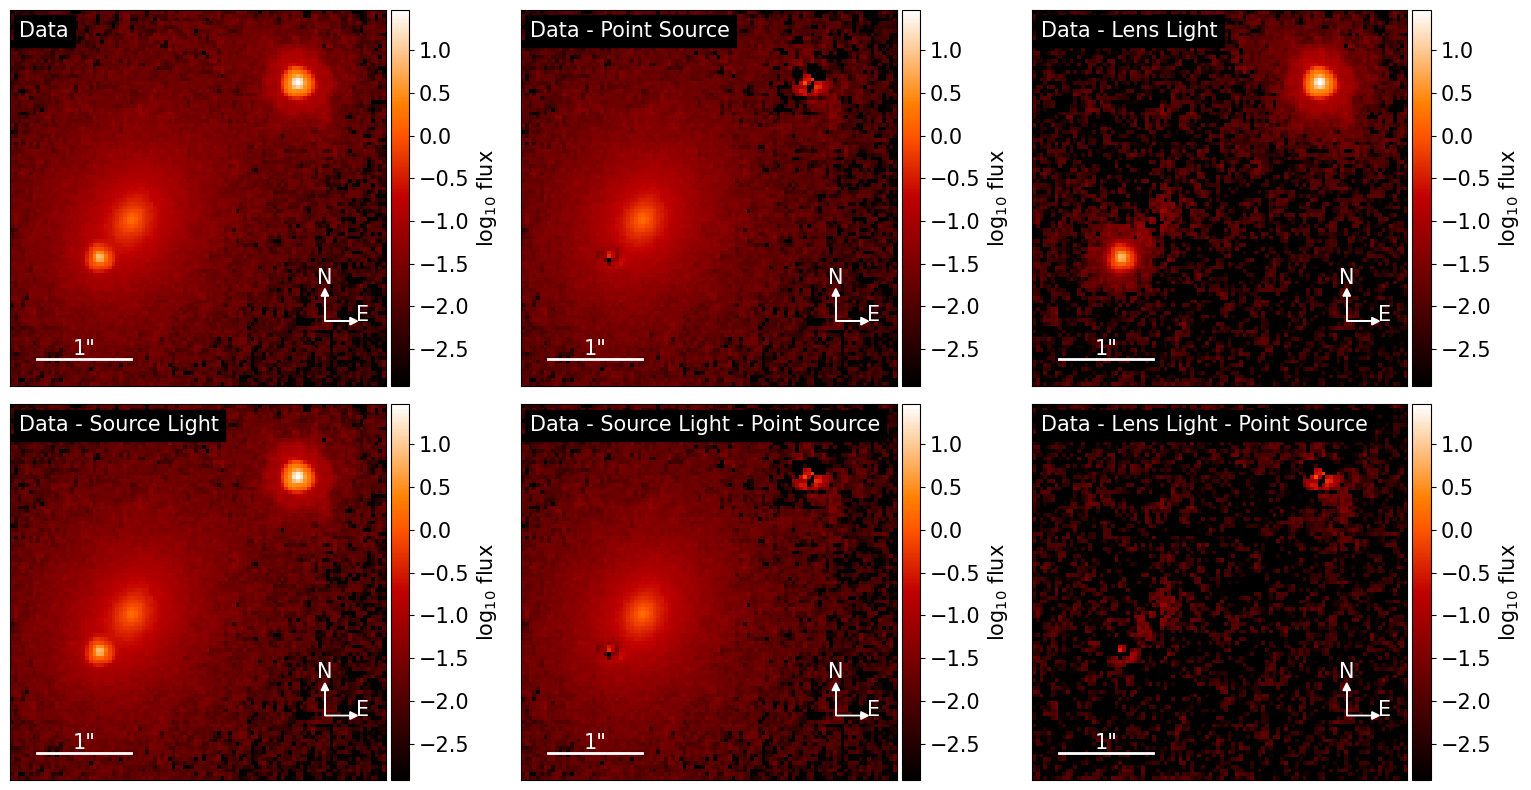

In [11]:
# run the fitting again with more iterations
fitting_kwargs_list = [
                       ['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 1000}],
                       ['psf_iteration', kwargs_psf_iter],
                       ['MCMC', {'n_burn': 100, 'n_run': 100, 'walkerRatio': 10,'sigma_scale': .1}]
]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
multi_band_list = fitting_seq.multi_band_list

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main()
display(f)

f, axes = modelPlot.plot_separate()
display(f)

f, axes = modelPlot.plot_subtract_from_data_all()
display(f)

number of non-linear parameters in the MCMC process:  19
parameters in order:  ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'ra_image', 'ra_image', 'dec_image', 'dec_image']
number of evaluations in the MCMC process:  19000


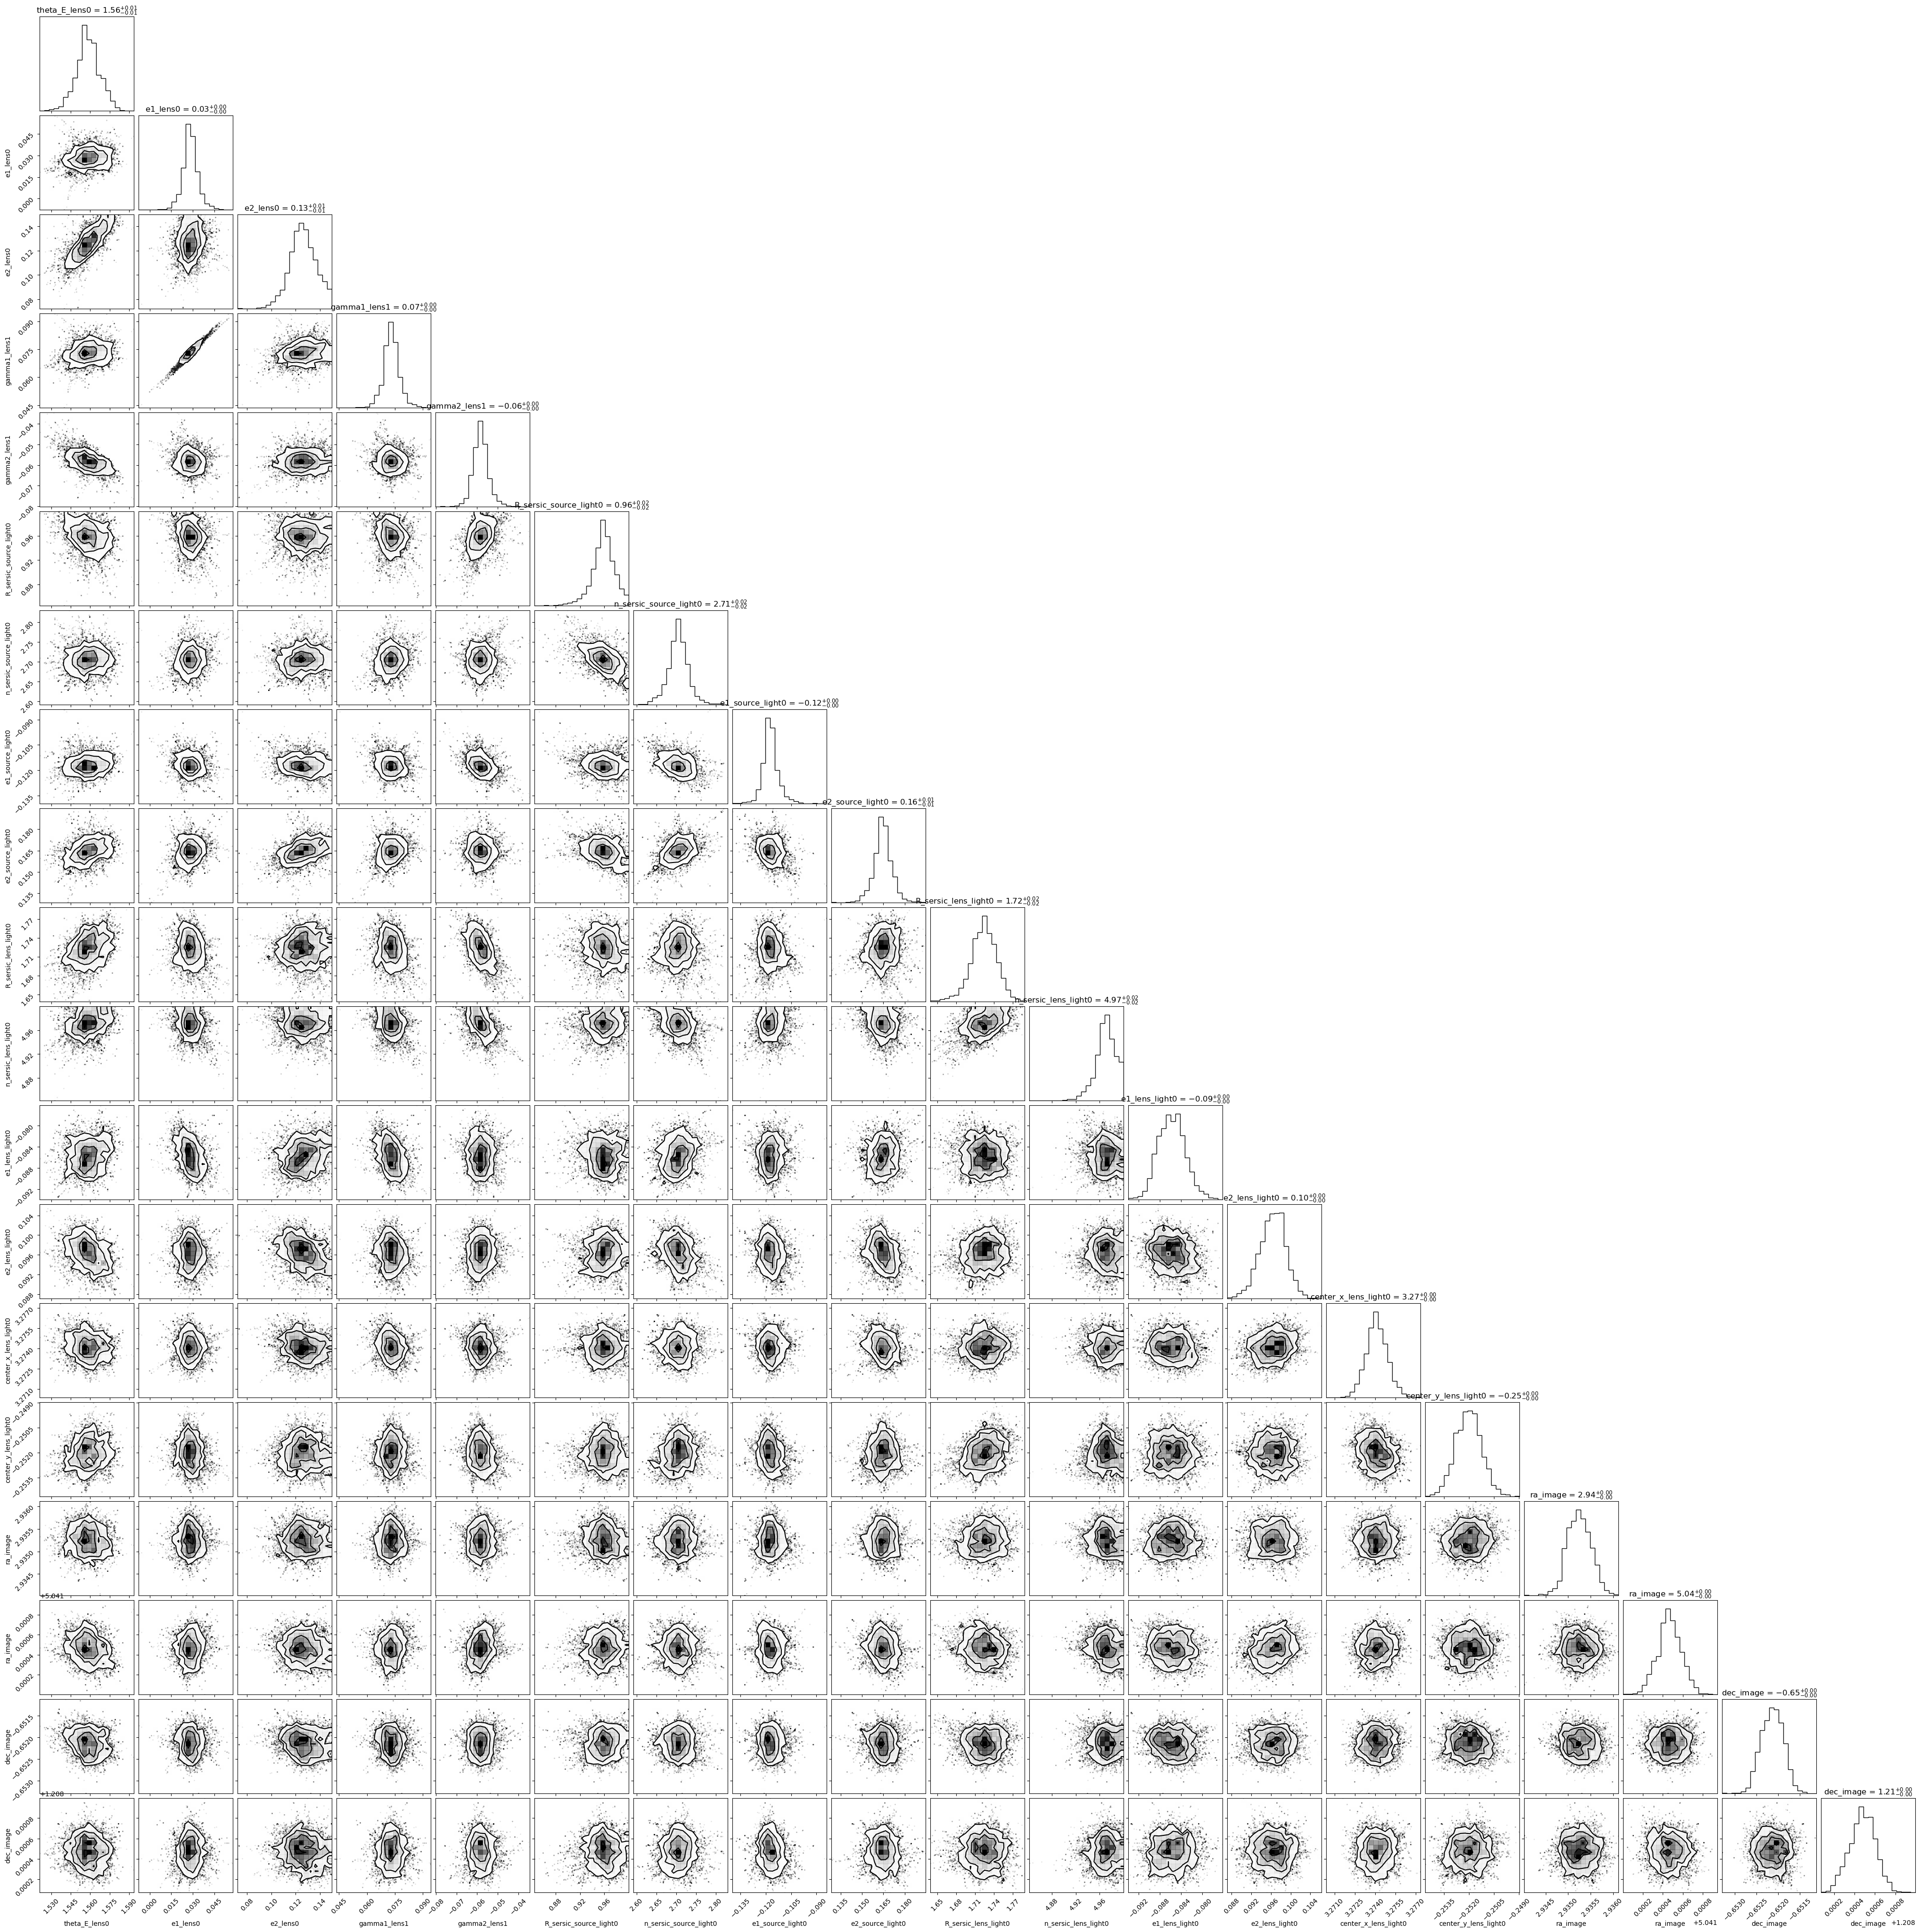

In [12]:
import corner
# analyze the PSO and MCMC chain
for i in range(len(chain_list)):
    plot_chain = chain_plot.plot_chain_list(chain_list, i)
plot_chain

sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])

if samples_mcmc.size != 0:
    n, num_param = np.shape(samples_mcmc)
    plot = corner.corner(samples_mcmc[:, :], labels=param_mcmc[:], show_titles=True)

plot

# Flux and Magnitude Calculation

modified from: [https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/Galaxies/quasar_host_galaxy_decomposition.ipynb]

In [13]:
# this is the linear inversion. The kwargs will be updated afterwards
from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource

data_class = ImageData(**kwargs_data)
lightModel = LightModel(lens_light_model_list)
pointSource = PointSource(point_source_list)

imageModel = ImageModel(data_class, psf_class, lens_light_model_class=lightModel,
                                point_source_class=pointSource, kwargs_numerics=kwargs_numerics)

imageLinearFit = ImageLinearFit(data_class=data_class, psf_class=psf_class,
                        lens_light_model_class=lightModel,
                        point_source_class=pointSource, 
                        kwargs_numerics=kwargs_numerics)
lens_light_result = kwargs_result['kwargs_lens_light']
ps_result = kwargs_result['kwargs_ps']
image_reconstructed, _, _, _ = imageLinearFit.image_linear_solve(kwargs_lens_light=lens_light_result, kwargs_ps=ps_result)
# flux count in point source
image_ps = imageModel.point_source(ps_result)
ps_flux = ps_result[0]['point_amp']
print('Point Source Flux:', ps_flux)
# for point sources, the fluxes in 'point_amp' are equivalent to the flux counts in the image.
# The only difference is the smaller cutout size in the image

# flux count in host galaxy
image_host = imageModel.lens_surface_brightness(lens_light_result)
lens_flux = np.sum(image_host)
print('Host Galaxy Flux:', lens_flux)


Point Source Flux: [ 67.48200024 268.35086591]
Host Galaxy Flux: 292.55497870589517


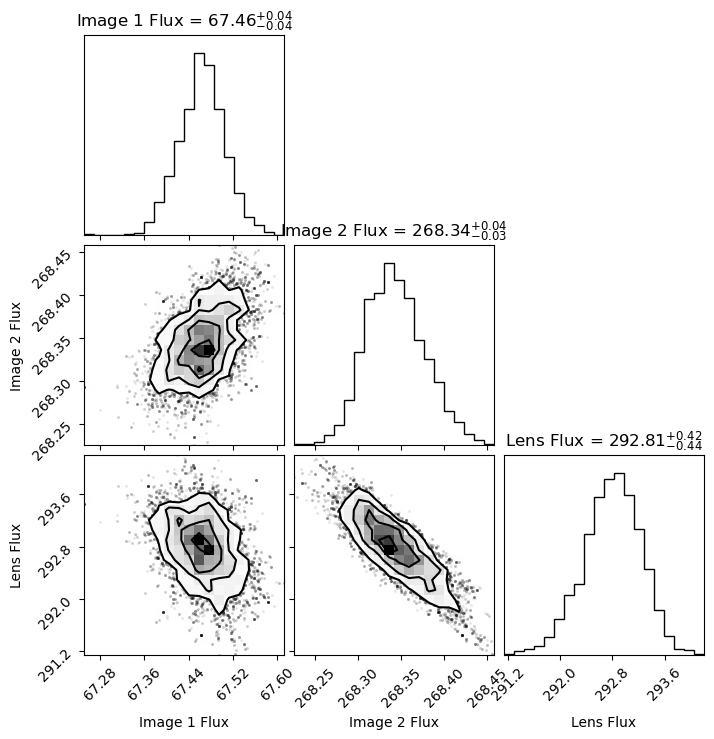

In [14]:
# plot posteriors on the flux calculations
from lenstronomy.Sampling.parameters import Param

param = Param(kwargs_model, kwargs_fixed_lens=[{'gamma': 2}, {'ra_0': 0, 'dec_0': 0}],
               kwargs_fixed_lens_light=[{}], kwargs_fixed_source=[{}], kwargs_fixed_ps=[{}], **kwargs_constraints)

sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

mcmc_new_list = []
labels_new = [r"Image 1 Flux", r"Image 2 Flux", r"Lens Flux"]
for i in range(len(samples_mcmc)):
    # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments
    kwargs_out = param.args2kwargs(samples_mcmc[i])
    kwargs_light_lens_out = kwargs_out['kwargs_lens_light']
    kwargs_ps_out = kwargs_out['kwargs_ps']
    image_reconstructed, _, _, _ = imageLinearFit.image_linear_solve(kwargs_lens_light=kwargs_light_lens_out, kwargs_ps=kwargs_ps_out)

    image_ps = imageModel.point_source(kwargs_ps_out)
    flux_im1 = kwargs_ps_out[0]['point_amp'][0]
    flux_im2 = kwargs_ps_out[0]['point_amp'][1]

    image_lens = imageModel.lens_surface_brightness(kwargs_light_lens_out, k=0)
    flux_lens = np.sum(image_lens)

    mcmc_new_list.append([flux_im1, flux_im2, flux_lens])

plot = corner.corner(np.array(mcmc_new_list), labels=labels_new, show_titles=True)
plot

In [15]:
# this is for easier saving of data, instead of hand-writing the sigma values from the posteriors
mcmc_new_array = np.array(mcmc_new_list)

# extract fluxes for quasar images and lens
im1_fluxes = mcmc_new_array[:, 0]
im2_fluxes = mcmc_new_array[:, 1]
lens_fluxes = mcmc_new_array[:, 2]

# calculate median and 1-sigma uncertainties
def get_median_and_uncertainties(samples):
    median = np.median(samples)
    lower, upper = np.percentile(samples, [16, 84])
    return median, lower, upper

# get values for each component
im1_flux_median, im1_flux_lower, im1_flux_upper = get_median_and_uncertainties(im1_fluxes)
im2_flux_median, im2_flux_lower, im2_flux_upper = get_median_and_uncertainties(im2_fluxes)
lens_flux_median, lens_flux_lower, lens_flux_upper = get_median_and_uncertainties(lens_fluxes)

# calculate 1-sigma intervals
im1_flux_sigma = (im1_flux_upper - im1_flux_median, im1_flux_median - im1_flux_lower)
im2_flux_sigma = (im2_flux_upper - im2_flux_median, im2_flux_median - im2_flux_lower)
lens_flux_sigma = (lens_flux_upper - lens_flux_median, lens_flux_median - lens_flux_lower)

# display results
print(f"Image 1 Flux: {im1_flux_median:.2f} (+{im1_flux_sigma[0]:.2f}, -{im1_flux_sigma[1]:.2f})")
print(f"Image 2 Flux: {im2_flux_median:.2f} (+{im2_flux_sigma[0]:.2f}, -{im2_flux_sigma[1]:.2f})")
print(f"Lens Flux: {lens_flux_median:.2f} (+{lens_flux_sigma[0]:.2f}, -{lens_flux_sigma[1]:.2f})")


Image 1 Flux: 67.46 (+0.04, -0.04)
Image 2 Flux: 268.34 (+0.04, -0.03)
Lens Flux: 292.81 (+0.42, -0.44)


In [16]:
# prep for magnitude calculations
def prep_phot_pars_array():
        
    filename = 'J1620+1203_F814W_cutout.fits'

    with fits.open(filename) as hdul:
        header = hdul[0].header
    
    photzpt =  header['photzpt']
    photflam = header['photflam']
    photplam = header['photplam']
    
    return [photflam, photzpt, photplam]

def get_stmag(electron_flux):
   
   photflam, photzpt, photplam = prep_phot_pars_array()
   
   flux = np.asarray(electron_flux)
   scalar_input = False
   if flux.ndim == 0:
      flux = flux[None]  
      scalar_input = True

   flux = flux * photflam
   mag = -2.5 * np.log10(flux) + photzpt

   if scalar_input:
       return np.squeeze(mag)

   return mag

# calculate AB magnitude
def get_abmag(electron_flux):
   stmag = get_stmag(electron_flux)

   photflam, photzpt, photplam = prep_phot_pars_array()

   return stmag - 5. * np.log10(photplam) + 2.5 * np.log10(299792458e10) - 27.5


quasar_mags = get_abmag(ps_flux)
print(f'Quasar Image AB Magnitudes: {quasar_mags}')

lens_mag = get_abmag(lens_flux)
print(f'Lens AB Magnitude: {lens_mag}')

Quasar Image AB Magnitudes: [20.53874783 19.0399602 ]
Lens AB Magnitude: 18.94619896633275


In [17]:
# save the final products in HDF5 format
with h5py.File('J1620+1203_F814W_final.hdf5', 'w') as f:
        f.create_dataset('image_position', data=[ps_result[0]['ra_image'], ps_result[0]['dec_image']])
        f.create_dataset('image_fluxes', data=kwargs_ps_out[0]['point_amp'])
        f.create_dataset('image_fluxes_sigma', data=[np.asarray(im1_flux_sigma), np.asarray(im2_flux_sigma)])
        f.create_dataset('image_mags', data=quasar_mags)
        for i, result in enumerate(lens_light_result):
            for key, value in result.items():
                f.create_dataset(key, data=value)
        # remove the 'amp' dataset
        del f['amp']

        f.create_dataset('lens_flux', data=lens_flux)
        f.create_dataset('lens_flux_sigma', data=np.asarray(lens_flux_sigma))
        f.create_dataset('lens_mag', data=lens_mag)


In [18]:
# save the data for later analysis
import pickle

save_dict = {
    "fitting_seq": fitting_seq,
    "kwargs_result": kwargs_result,
    "multi_band_list": multi_band_list,
    "kwargs_model": kwargs_model,
    "kwargs_params": kwargs_params,
    "chain_list": chain_list,
    "kwargs_constraints": kwargs_constraints,
    "kwargs_likelihood": kwargs_likelihood,
    "kwargs_data_joint": kwargs_data_joint
}

with open("J1620+1203_F814W_fit.pkl", "wb") as f:
    pickle.dump(save_dict, f)
